In [6]:
import numpy as np
import xarray as xr
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [8]:
simu = 'AMOPL'
# simu = 'A0W0V'
# simu = 'ATRI2'
# simu = 'ACON2'
# simu = 'AMO20'
# simu = 'CTRI2'
# simu = 'CFLAT'
# simu = 'CMO10'

orog=True

# userPath = '/cnrm/tropics/user/philippotn'
userPath = '/home/philippotn'
    
if userPath == '/home/philippotn':
    dataPath = userPath+'/Documents/SIMU_LES/'
    objectsPath = userPath+'/Documents/objects/LES_'+simu+'/1M_thermals/'
else:
    dataPath = userPath+'/LES_'+simu+'/NO_SAVE/'
    objectsPath = userPath+'/LES_'+simu+'/characs_objects/1M_thermals/'

if simu == 'AMOPL':
    seg = 'M200m'# ; lFiles = [dataPath + 'AMOPL.1.200m1.OUT.{:03d}.nc'.format(i) for i in range(1,241,1)] + [dataPath + 'AMOPL.1.200m2.OUT.{:03d}.nc'.format(i) for i in range(1,722,1)]
    lFiles = [dataPath + 'AMOPL.1.200m1.OUT.{:03d}.nc'.format(i) for i in [60,120,180,240]]+[dataPath + 'AMOPL.1.200m2.OUT.{:03d}.nc'.format(i) for i in [60,120,180,240,300,360,420,480,540,600,660,720]]
elif simu== 'A0W0V':
    seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,1)]
elif simu== 'ATRI2':
    seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,60)]
elif simu== 'ACON2':
    seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,1)]
elif simu== 'AMO20':
    seg = 'M200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in [1,61,121,181,241,301,361,421,481,541,601,661,699]]#range(1,961,1)]
elif simu== 'CTRI2':
    seg = 'M100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,872,1)]
elif simu== 'CFLAT':
    seg = 'S100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,872,1)]
elif simu== 'CMO10':
    seg = 'M100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(2,3,1)]

f0 = xr.open_dataset(lFiles[0],engine='h5netcdf')

nx1 = 1 ; nx2 = len(f0.ni)-1
ny1 = 1 ; ny2 = len(f0.nj)-1
nz1 = 1 ; nz2 = len(f0.level)

x = np.array(f0.ni)[nx1:nx2]
y = np.array(f0.nj)[ny1:ny2]
z = np.array(f0.level)[nz1:nz2]
z_ = np.array(f0.level_w)[nz1:nz2]
dz = z_[1:]-z_[:-1]
dz = np.append(dz,dz[-1])

dx = x[1]-x[0]
nt,nz,ny,nx = len(lFiles),len(z),len(y),len(x)

if orog:
    ZS = xr.open_dataset(dataPath+simu+'_init_'+seg+'_pgd.nc')['ZS'][ny1:ny2,nx1:nx2].data
    ZSmean = np.mean(ZS)
    MO = ZS>ZSmean # Mountain region (upper one)
    PL = np.logical_not(MO) # Plain region (lower one)
else:
    ZS = np.zeros((ny,nx))
    
nt = len(lFiles)

def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 50, fill = '█', printEnd = "\r"):
    ratio = str(iteration)+' / '+str(total)
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {ratio} {suffix}', end = printEnd)
    if iteration == total: # Print New Line on Complete
        print()

In [4]:
list_area=[]
list_charac=[]
list_pos=[]
lFiles = [dataPath+'objects_charac_area_pos.{:03d}.npz'.format(i) for i in range(1,1+nt)]
print("Chargement des données de charactérisation d'objets :")
for it,file in enumerate(lFiles):
    cap = np.load(file)
    list_area.append(cap['area'])
    list_pos.append(cap['pos'])
    list_charac.append(cap['charac'])
    printProgressBar(it+1,nt)

Chargement des données de charactérisation d'objets :
 |██████████████████████████████████████████████████| 17 / 17 


(0.0, 6.0)

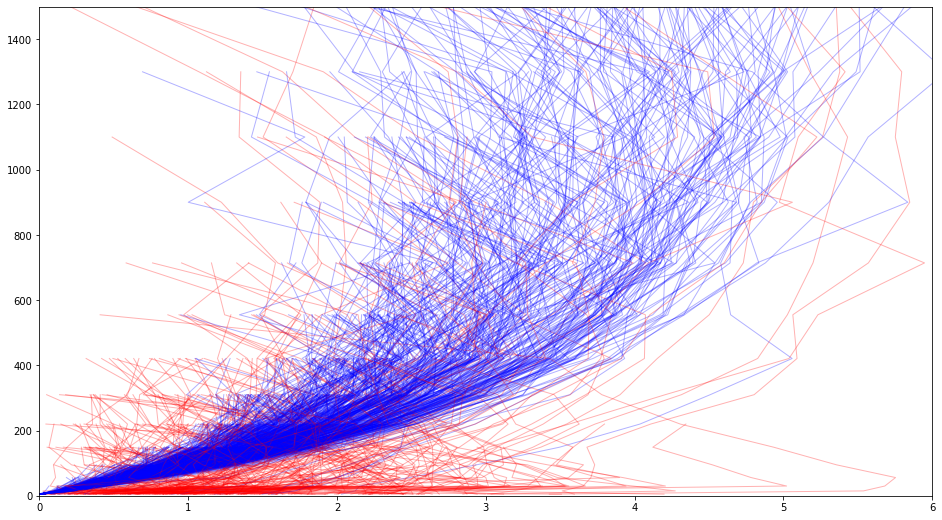

In [38]:
it = 10
plt.figure(figsize=(16,9))
PL = list_charac[it][:,0,5,0] > 98500
MO = list_charac[it][:,0,5,0] < 90000
for i in range(len(list_charac[it])):
    if PL[i]:
        plt.plot(list_charac[it][i,:,2,3],z,color='b',linewidth=1,alpha=0.3)
    if MO[i]:
        plt.plot(list_charac[it][i,:,2,3],z,color='r',linewidth=1,alpha=0.3)
plt.ylim([0,3000])
plt.xlim([0,6])

(0.0, 6.0)

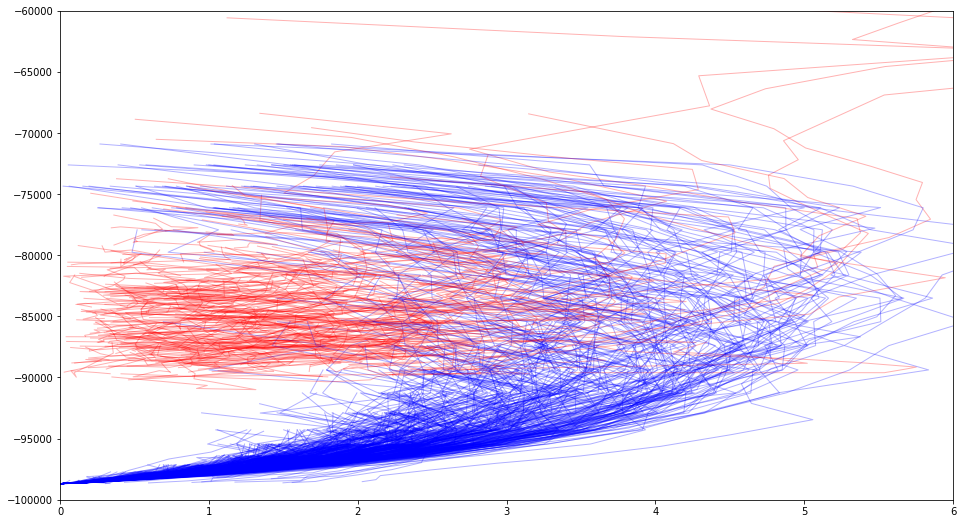

In [39]:
it = 10
plt.figure(figsize=(16,9))
PL = list_charac[it][:,0,5,0] > 98000
MO = list_charac[it][:,0,5,0] < 90000
for i in range(len(list_charac[it])):
    if PL[i]:
        plt.plot(list_charac[it][i,:,2,3],-list_charac[it][i,:,5,0],color='b',linewidth=1,alpha=0.3)
    if MO[i]:
        plt.plot(list_charac[it][i,:,2,3],-list_charac[it][i,:,5,0],color='r',linewidth=1,alpha=0.3)
plt.ylim([-100000,-60000])
plt.xlim([0,6])